In [1]:
import torchvision as tv
import torch as torch
import torch.nn.functional as F
import time

# Data - CIFAR10

In [2]:
# From the pytorch docs:
# All pre-trained models expect input images normalized in the same way,
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W),
# where H and W are expected to be at least 224. The images have to be
# loaded in to a range of [0, 1] and then normalized using
# mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

normalize = tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
tfm = tv.transforms.Compose([tv.transforms.RandomResizedCrop(224),
                                tv.transforms.RandomHorizontalFlip(),
                                tv.transforms.ToTensor(),
                                normalize])

trainset = tv.datasets.CIFAR10('./data', train=True, download=True, transform=tfm)
testset = tv.datasets.CIFAR10('./data', train=False, download=True, transform=tfm)

batch_size = 4
n_work = 1
learn_rate = 1e-3
epochs = 1

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=n_work)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=n_work)

Files already downloaded and verified
Files already downloaded and verified


# Train Loop

In [4]:
def adjust_learning_rate(optimizer, epoch):
    ''' reduce the learning rate by a factor of 10 every 30 epochs'''
    lr_factor = 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = learn_rate * lr_factor
        
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    _, preds = output.topk(maxk, 1, True, True)
    topk_targets = target.view(-1, 1).expand_as(preds) 
    correct = topk_targets == preds
    res = []
    for k in topk:
        num_correct = correct[:,:k].sum().item()
        res.append(100 * num_correct / correct.size(0))
    return res

In [58]:
def train_tickers_description(tickers):
    dt, bt, t1a, t5a, loss = tickers['data_time'], tickers['batch_time'], tickers['top1_accuracy'], tickers['top5_accuracy'], tickers['loss']
    avg = lambda t: t[0] / t[1]
    return f' data time: {avg(dt)} \
             \n batch time: {avg(bt)} \
             \n top1 accuracy: {avg(t1a)} \
             \n top5 accuracy: {avg(t5a)} \
             \n loss: {avg(loss)}\n'

def train_epoch(trainloader, model, criterion, optimizer, print_freq=100):
    ''' run a single epoch of training'''
    model.train()
    tickers = {'data_time' : torch.zeros(2),
               'batch_time' : torch.zeros(2),
               'top1_accuracy' : torch.zeros(2),
               'top5_accuracy' : torch.zeros(2),
               'loss' : torch.zeros(2)}
    end = time.time()
    for idx, (input, target) in enumerate(trainloader):
        tickers['data_time'] += torch.tensor([time.time() - end, 1])
        output = model(input)
        loss = criterion(output, target)
        acc1, acc5 = accuracy(output, target,(1,5))
        tickers['top1_accuracy'] += torch.tensor([acc1, 1])
        tickers['top5_accuracy'] += torch.tensor([acc5, 1])
        tickers['loss'] += torch.tensor([loss.data, 1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tickers['batch_time'] += torch.tensor([time.time() - end, 1])
        end = time.time()
        bs = input.size(0)
        if idx % print_freq == 0:
            print(train_tickers_description(tickers))
        #if idx > 500: break

In [108]:
def test_tickers_description(tickers):
    bt, t1a, t5a = tickers['batch_time'], tickers['top1_accuracy'], tickers['top5_accuracy']
    avg = lambda t: t[0] / t[1]
    return f' batch time: {avg(bt)} \
             \n top1 accuracy: {avg(t1a)} \
             \n top5 accuracy: {avg(t5a)} \n'

def test(testloader, model, criterion, print_freq=100):
    ''' evaluate the model'''
    model.eval()
    tickers = {'data_time' : torch.zeros(2),
               'batch_time' : torch.zeros(2),
               'top1_accuracy' : torch.zeros(2),
               'top5_accuracy' : torch.zeros(2),
               'loss' : torch.zeros(2)}
    end = time.time()
    for idx, (input, target) in enumerate(testloader):
        output = model(input)
        loss = criterion(output, target)
        acc1, acc5 = accuracy(output, target, (1, 5))
        tickers['top1_accuracy'] += torch.tensor([acc1, 1])
        tickers['top5_accuracy'] += torch.tensor([acc5, 1])
        tickers['batch_time'] += torch.tensor([time.time() - end, 1])
        end = time.time()
        bs = input.size(0)
        if idx % print_freq == 0:
            print(test_tickers_description(tickers))
    t1a = tickers['top5_accuracy']
    return t1a[0] / t1a[1]

In [107]:
def fit(model, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), learn_rate, momentum=0.9, weight_decay=1e-4)
    for epoch in range(1, epochs + 1):
        print(f'Epoch: {epoch} \n')
        adjust_learning_rate(optimizer, epoch)
        train_epoch(trainloader, model, criterion, optimizer)
        top1acc = test(testloader, model, criterion)
        print(top1acc.data)

# Model - dummy

In [109]:
class Net(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(224 * 224 * 3, 10)
            
    def forward(self, x):        
        return self.fc1(x.view(-1, 3 * 224 * 224))
    
fit(Net(), 1)

Epoch: 1 

 data time: 0.026875019073486328              
 batch time: 0.054234981536865234              
 top1 accuracy: 0.0              
 top5 accuracy: 25.0              
 loss: 2.8279504776000977

 data time: 0.0007960395305417478              
 batch time: 0.009950656443834305              
 top1 accuracy: 14.10891056060791              
 top5 accuracy: 60.14851379394531              
 loss: 224.140869140625

 data time: 0.000675041286740452              
 batch time: 0.009447149001061916              
 top1 accuracy: 15.796019554138184              
 top5 accuracy: 60.199005126953125              
 loss: 252.91220092773438

 data time: 0.0006249228026717901              
 batch time: 0.009144889190793037              
 top1 accuracy: 16.02989959716797              
 top5 accuracy: 61.627906799316406              
 loss: 270.8465270996094

 data time: 0.00059844134375453              
 batch time: 0.009017663076519966              
 top1 accuracy: 15.586034774780273              

# Model - [VGG](https://arxiv.org/pdf/1409.1556.pdf) (2015)

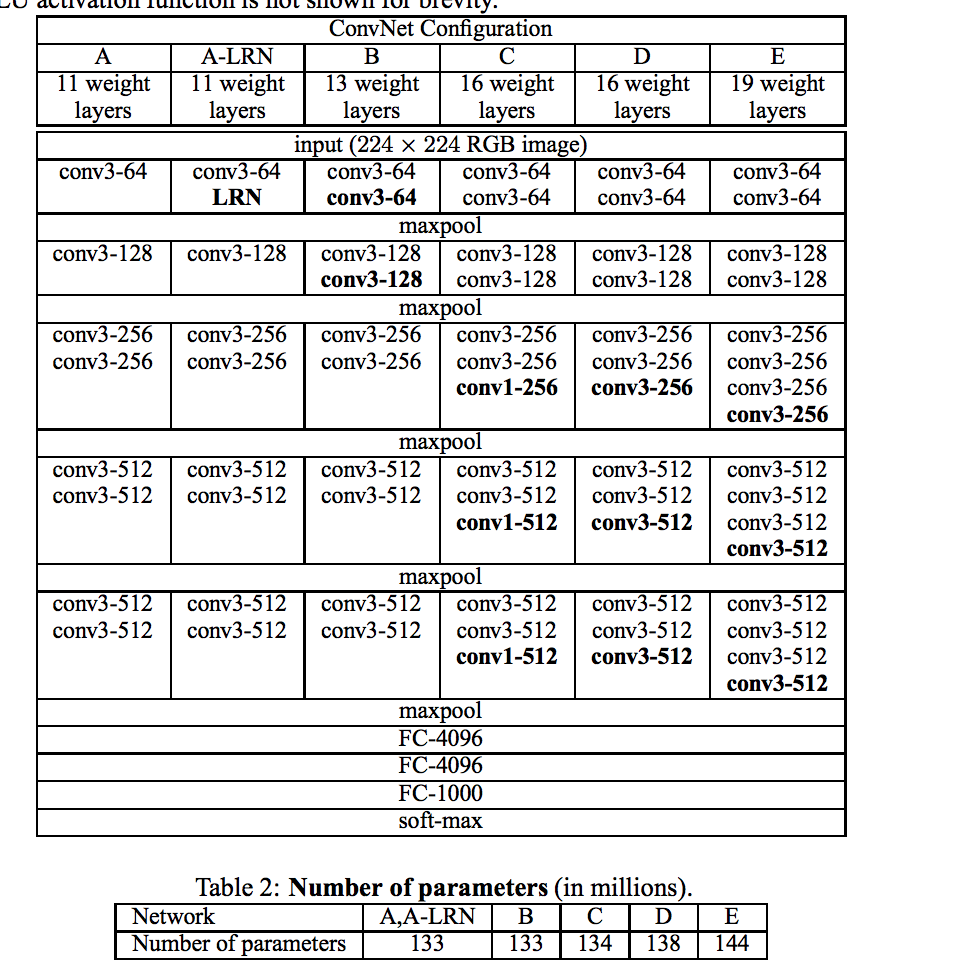

- Convolution is performed over a 3 x 3 pixel window, with stride 1 (with exception of 1 x 1 in architecture c). The spatial padding of conv. layer input is such that the spatial resolution is preserved
after convolution, i.e. the padding is 1 pixel for 3 × 3 conv. layers
- Max-pooling is performed over a 2 × 2 pixel window, with stride 2. Making the side of the spatial input to first fc layer = $\dfrac{224}{2^ 5} = 7$
- All hidden layers are equipped with the rectification non-linearity.
- Dropout regularisation for the first two fully-connected layers (dropout ratio set to 0.5)

In [103]:
class VGG(torch.nn.Module):
    
    def __init__(self, conv_layers):
        super().__init__()
        self.conv_layers = conv_layers
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(512 * 7 * 7, 4096),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 1000)
            # omitting the final softmax layer
            # see discussion here - https://discuss.pytorch.org/t/vgg-output-layer-no-softmax/9273/4
            # .. long and short of it is that pytorch's CrossEntropy loss implementation includes
            # a log softmax - https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)
    
archs = {'A' : [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
         'B' : [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
         'D' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
         'E' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']}

def make_layers(layer_spec):
    layers = []
    in_channels = 3
    for l in layer_spec:
        if l == 'M':
            layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
        else:
            layers.append(torch.nn.Conv2d(in_channels, l, kernel_size=3, padding=1))
            layers.append(torch.nn.ReLU())
            in_channels = l
            
    return torch.nn.Sequential(*layers)

def vgg11():
    return VGG(make_layers(archs['A']))

def vgg13():
    return VGG(make_layers(archs['B']))

def vgg16():
    return VGG(make_layers(archs['D']))

def vgg16():
    return VGG(make_layers(archs['E']))

In [105]:
#fit(vgg11(), 1)
#fit(tv.models.vgg11(), 1)